In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from io import StringIO

In [2]:
import json
import pandas as pd
import numpy as np


class DataSpace:
    def __init__(self, min_bin_population=10):
        self.data = {}
        self.metadata = {}
        self.min_bin_population = min_bin_population

    def create_user_space(self, df_name_list):
        space = DataSpace(min_bin_population=self.min_bin_population)
        for df_name in df_name_list:
            space.data[df_name] = self.data[df_name]
            space.metadata[df_name] = self.metadata[df_name]

        return space

    ### df_methods ###

    def copy_df(self, df_name, new_df_name):
        if new_df_name in self.data:
            return 'A dataframe with that name already exists, aborting.'

        self.data[new_df_name] = self.data[df_name].copy()
        # Deep copy metadata dictionary to avoid references
        self.metadata[new_df_name] = {
            'columns': {col_name: col_meta.copy() for col_name, col_meta in self.metadata[df_name]['columns'].items()}
        }

        return 'Operation successful.'

    def drop_df(self, df_name):
        del self.data[df_name]
        del self.metadata[df_name]
        return 'Operation successful.'

    def drop_column(self, df_name, column):
        self.data[df_name].drop(column, axis=1, inplace=True)
        # Remove the column from the metadata dictionary
        if column in self.metadata[df_name]['columns']:
            del self.metadata[df_name]['columns'][column]
        return 'Operation successful.'

    def filter_df(self, df_name, column, value):
        df = self.data[df_name][self.data[df_name][column] == value]
        if len(df) < self.min_bin_population:
            return 'Operation would result in a dataframe with less than the minimum bin population, aborting.'
        else:
            self.data[df_name] = df
            return 'Operation successful.'

    def merge_df(self, left_df_name, right_df_name, on, new_df_name, how='inner'):
        # Check if the new dataframe name is already used
        if new_df_name in self.data:
            return 'A dataframe with that name already exists, aborting.'

        # Check that both dataframes exist
        if left_df_name not in self.data or right_df_name not in self.data:
            return 'One or both of the specified dataframes do not exist, aborting.'

        # Perform the merge operation
        merged_df = self.data[left_df_name].merge(
            self.data[right_df_name], on=on, how=how)

        # Check the size of the merged dataframe
        if len(merged_df) < self.min_bin_population:
            return 'Operation would result in a dataframe with less than the minimum bin population, aborting.'

        # Combine metadata from both dataframes
        left_metadata_cols = self.metadata[left_df_name]['columns']
        right_metadata_cols = self.metadata[right_df_name]['columns']

        combined_metadata = {}
        for col_name in merged_df.columns:
            if col_name in left_metadata_cols:
                combined_metadata[col_name] = left_metadata_cols[col_name]
            elif col_name in right_metadata_cols:
                combined_metadata[col_name] = right_metadata_cols[col_name]
            else:
                # If the column doesn't appear in either metadata,
                # create a default metadata entry for it.
                combined_metadata[col_name] = {
                    "type": "unknown",
                    "description": "No metadata found."
                }

        # Store the merged data and metadata
        self.data[new_df_name] = merged_df
        self.metadata[new_df_name] = {
            'columns': combined_metadata
        }

        return 'Operation successful.'

    def rename_column(self, df_name, old_column, new_column):
        if new_column in self.data[df_name].columns:
            return 'A column with that name already exists, aborting.'

        self.data[df_name].rename(
            columns={old_column: new_column}, inplace=True)

        # Update the metadata dictionary keys
        if old_column in self.metadata[df_name]['columns']:
            col_data = self.metadata[df_name]['columns'].pop(old_column)
            self.metadata[df_name]['columns'][new_column] = col_data

        return 'Operation successful.'

    ######

    def add_data_from_data_and_metadata_files(self, df_name, data_file, metadata_file):
        with open(metadata_file) as f:
            metadata = json.load(f)
            self.metadata[df_name] = metadata

        df = pd.read_csv(data_file)
        self.data[df_name] = df

    @property
    def sources(self):
        return list(self.data.keys())

    def columns(self, source):
        if source not in self.data:
            return None

        return self.data[source].columns

    def _distribution_of(self, df, column, bin_ranges=None):
        if column not in df.columns:
            return None

        valid_data = df[column].dropna()

        if bin_ranges is None:
            bin_ranges = np.histogram_bin_edges(valid_data, bins='auto')

        distribution_counts, bin_edges = np.histogram(
            valid_data, bins=bin_ranges)

        distribution_df = pd.DataFrame({
            'Bin Range': [f"{bin_edges[i]} - {bin_edges[i + 1]}" for i in range(len(bin_edges) - 1)],
            'Count': distribution_counts
        })

        distribution_df.loc[distribution_df['Count']
                            < self.min_bin_population, 'Count'] = 0

        return distribution_df

    def request_distribution_of(self, source, column, bin_ranges=None):
        if source not in self.data:
            return None

        df = self.data[source]
        distribution_df = self._distribution_of(df, column, bin_ranges)
        return distribution_df.to_json()

    def request_metadata(self, source):
        if source not in self.metadata:
            return None

        return self.metadata[source]

    def _column_metadata(self, source, column):
        if source not in self.metadata:
            return None

        return self.metadata[source]['columns'].get(column, None)

    def request_column_metadata(self, source, column):
        return self._column_metadata(source, column)

    def request_is_column_standard_unique_identifier(self, source, column):
        metadata = self._column_metadata(source, column)
        return metadata.get('is_standard_unique_identifier', False) if metadata else False

    def request_length_of_df(self, source):
        return len(self.data[source])

    def info(self):
        for source in self.sources:
            print(f"Source: {source}")
            print(f"Columns: {self.columns(source)}")
            print(f"Length: {self.request_length_of_df(source)}")
            print(f"Metadata: {self.request_metadata(source)}")
            print()

In [3]:
hagstofa_data = DataSpace()
hagstofa_data.add_data_from_data_and_metadata_files(
    'hagstofa', 'hagstofa_data.csv', 'hagstofa_metadata.json')
hagstofa_data.add_data_from_data_and_metadata_files(
    'medical', 'medical_data.csv', 'medical_metadata.json')

In [4]:
print(f'Hagstofa columns: {hagstofa_data.columns("hagstofa")}')
print(
    f"length of hagstofa data: {hagstofa_data.request_length_of_df('hagstofa')}")
print(f'Medical columns: {hagstofa_data.columns("medical")}')
print(
    f"length of medical data: {hagstofa_data.request_length_of_df('medical')}")

Hagstofa columns: Index(['Name', 'Age', 'Gender', 'Birth Date', 'Kennitala', 'Income', 'Email'], dtype='object')
length of hagstofa data: 13308
Medical columns: Index(['Name', 'Age', 'Gender', 'Birth Date', 'Kennitala', 'Gout', 'Obesity',
       'Stress-Related Disorders', 'Cardiovascular Diseases',
       'Eating Disorders', 'Addiction', 'Rare Genetic Disease',
       'Common Allergies', 'Hereditary Condition', 'patient_id'],
      dtype='object')
length of medical data: 5000


In [5]:
print(f'Hagstofa metadata: {hagstofa_data.request_metadata("hagstofa")}')
print(
    f"Hagstofa income metadata: {hagstofa_data.request_column_metadata('hagstofa', 'Income')}")

print(
    f"Hagstofa Kennitala metadata: {hagstofa_data.request_column_metadata('hagstofa', 'Kennitala')}")
print(
    f"Hagstofa Kennitala is standard unique identifier: {hagstofa_data.request_is_column_standard_unique_identifier('hagstofa', 'Kennitala')}")
print(
    f"Medical Kennitala is standard unique identifier: {hagstofa_data.request_is_column_standard_unique_identifier('medical', 'Kennitala')}")

Hagstofa metadata: {'dataset_name': 'Sample Personal Information Dataset', 'description': 'This dataset contains personal details of individuals, including name, age, gender, birth date, identification number (kennitala), income, and email address.', 'columns': {'Name': {'type': 'string', 'description': 'Full name of the individual, including first and last name.'}, 'Age': {'type': 'float', 'description': 'Age of the individual in years, expressed with decimal precision.'}, 'Gender': {'type': 'string', 'description': 'Gender of the individual (e.g., Male, Female).'}, 'Birth Date': {'type': 'date', 'format': 'YYYY-MM-DD', 'description': 'Birth date of the individual in ISO format.'}, 'Kennitala': {'type': 'string', 'is_standard_unique_identifier': True, 'description': 'Icelandic national identification number for the individual, unique to each person.'}, 'Income': {'type': 'float', 'description': 'Yearly income of the individual in thousands ISK, expressed as a floating-point number.'},

In [6]:
income_bins = np.linspace(0, 20000, 21)  # 20 bins between 0 and 20,000
full_income_distribution = hagstofa_data.request_distribution_of(
    'hagstofa', 'Income', bin_ranges=income_bins)
full_income_distribution_df = pd.read_json(StringIO(full_income_distribution))
display(full_income_distribution_df)

,Bin Range,Count
0,0.0 - 1000.0,0
1,1000.0 - 2000.0,442
2,2000.0 - 3000.0,655
3,3000.0 - 4000.0,670
4,4000.0 - 5000.0,702
5,5000.0 - 6000.0,1001
6,6000.0 - 7000.0,1512
7,7000.0 - 8000.0,2014
8,8000.0 - 9000.0,2359
9,9000.0 - 10000.0,2175


In [7]:
user_space = hagstofa_data.create_user_space(['hagstofa', 'medical'])
user_space.info()

Source: hagstofa
Columns: Index(['Name', 'Age', 'Gender', 'Birth Date', 'Kennitala', 'Income', 'Email'], dtype='object')
Length: 13308
Metadata: {'dataset_name': 'Sample Personal Information Dataset', 'description': 'This dataset contains personal details of individuals, including name, age, gender, birth date, identification number (kennitala), income, and email address.', 'columns': {'Name': {'type': 'string', 'description': 'Full name of the individual, including first and last name.'}, 'Age': {'type': 'float', 'description': 'Age of the individual in years, expressed with decimal precision.'}, 'Gender': {'type': 'string', 'description': 'Gender of the individual (e.g., Male, Female).'}, 'Birth Date': {'type': 'date', 'format': 'YYYY-MM-DD', 'description': 'Birth date of the individual in ISO format.'}, 'Kennitala': {'type': 'string', 'is_standard_unique_identifier': True, 'description': 'Icelandic national identification number for the individual, unique to each person.'}, 'Income'

In [8]:
user_space.copy_df('medical', 'research')

'Operation successful.'

In [9]:
user_space.info()

Source: hagstofa
Columns: Index(['Name', 'Age', 'Gender', 'Birth Date', 'Kennitala', 'Income', 'Email'], dtype='object')
Length: 13308
Metadata: {'dataset_name': 'Sample Personal Information Dataset', 'description': 'This dataset contains personal details of individuals, including name, age, gender, birth date, identification number (kennitala), income, and email address.', 'columns': {'Name': {'type': 'string', 'description': 'Full name of the individual, including first and last name.'}, 'Age': {'type': 'float', 'description': 'Age of the individual in years, expressed with decimal precision.'}, 'Gender': {'type': 'string', 'description': 'Gender of the individual (e.g., Male, Female).'}, 'Birth Date': {'type': 'date', 'format': 'YYYY-MM-DD', 'description': 'Birth date of the individual in ISO format.'}, 'Kennitala': {'type': 'string', 'is_standard_unique_identifier': True, 'description': 'Icelandic national identification number for the individual, unique to each person.'}, 'Income'

In [10]:
user_space.filter_df('research', 'Gout', True)

'Operation successful.'

In [11]:
user_space.info()

Source: hagstofa
Columns: Index(['Name', 'Age', 'Gender', 'Birth Date', 'Kennitala', 'Income', 'Email'], dtype='object')
Length: 13308
Metadata: {'dataset_name': 'Sample Personal Information Dataset', 'description': 'This dataset contains personal details of individuals, including name, age, gender, birth date, identification number (kennitala), income, and email address.', 'columns': {'Name': {'type': 'string', 'description': 'Full name of the individual, including first and last name.'}, 'Age': {'type': 'float', 'description': 'Age of the individual in years, expressed with decimal precision.'}, 'Gender': {'type': 'string', 'description': 'Gender of the individual (e.g., Male, Female).'}, 'Birth Date': {'type': 'date', 'format': 'YYYY-MM-DD', 'description': 'Birth date of the individual in ISO format.'}, 'Kennitala': {'type': 'string', 'is_standard_unique_identifier': True, 'description': 'Icelandic national identification number for the individual, unique to each person.'}, 'Income'

In [12]:
user_space.merge_df('hagstofa', 'research', 'Kennitala', 'merged')

'Operation successful.'

In [13]:
user_space.info()

Source: hagstofa
Columns: Index(['Name', 'Age', 'Gender', 'Birth Date', 'Kennitala', 'Income', 'Email'], dtype='object')
Length: 13308
Metadata: {'dataset_name': 'Sample Personal Information Dataset', 'description': 'This dataset contains personal details of individuals, including name, age, gender, birth date, identification number (kennitala), income, and email address.', 'columns': {'Name': {'type': 'string', 'description': 'Full name of the individual, including first and last name.'}, 'Age': {'type': 'float', 'description': 'Age of the individual in years, expressed with decimal precision.'}, 'Gender': {'type': 'string', 'description': 'Gender of the individual (e.g., Male, Female).'}, 'Birth Date': {'type': 'date', 'format': 'YYYY-MM-DD', 'description': 'Birth date of the individual in ISO format.'}, 'Kennitala': {'type': 'string', 'is_standard_unique_identifier': True, 'description': 'Icelandic national identification number for the individual, unique to each person.'}, 'Income'

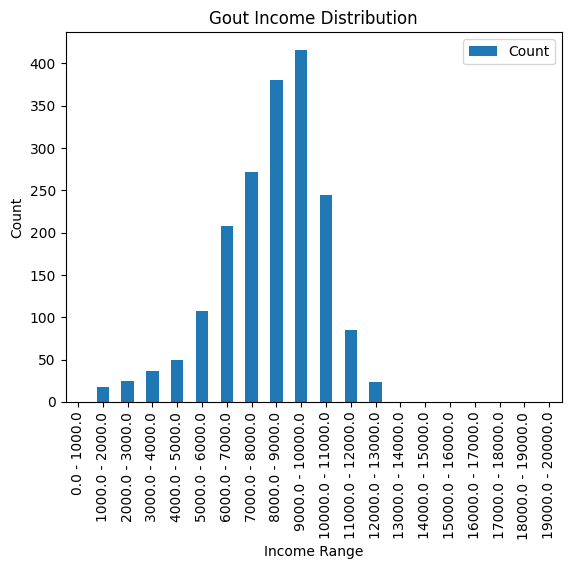

In [14]:
income_bins = np.linspace(0, 20000, 21)  # 20 bins between 0 and 20,000
gout_income_distribution = user_space.request_distribution_of(
    'merged', 'Income', bin_ranges=income_bins)
gout_income_distribution_df = pd.read_json(StringIO(gout_income_distribution))

gout_income_distribution_df.plot(x='Bin Range', y='Count', kind='bar')
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Gout Income Distribution')
plt.show()

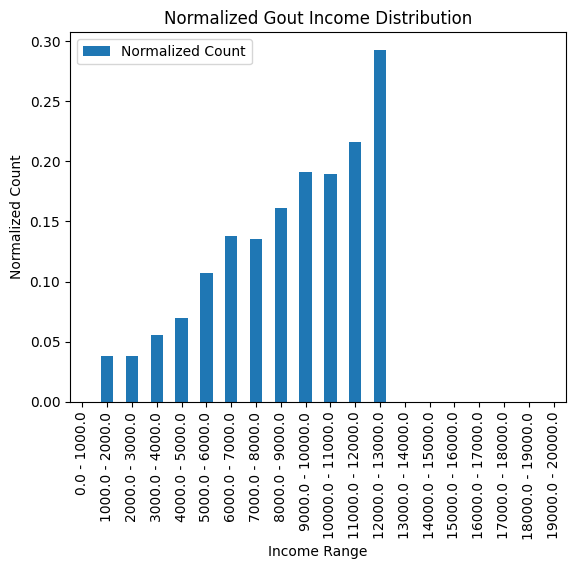

In [15]:
# Normalize the gout income distribution by the full income distribution
normalized_gout_income_distribution_df = gout_income_distribution_df.copy()
normalized_gout_income_distribution_df['Normalized Count'] = normalized_gout_income_distribution_df['Count'] / \
    full_income_distribution_df['Count']

# Plot the normalized gout income distribution
normalized_gout_income_distribution_df.plot(
    x='Bin Range', y='Normalized Count', kind='bar')
plt.xlabel('Income Range')
plt.ylabel('Normalized Count')
plt.title('Normalized Gout Income Distribution')
plt.show()